# Convergence and Optimality Analysis of Low-Dimensional Generative Adversarial Networks using Error Function Integrals

## Requirements

Use `requirements.txt` file preferably in virtual environment.

In order to do that in the current folder, for Ubuntu:
```
$ sudo apt install virtualenv
$ virtualenv venv
$ source venv/bin/activate
(venv)$ pip install -r requirements.txt
(venv)$ python -m ipykernel install --user --name=venv
```

Launch from command prompt: 
```bash
(venv)$ jupyter notebook
```

or open it within VSCode with [Jupyter extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) or any other favorite method. Please make sure that the Jupyter kernel points to your environment (select it from the kernel menu).

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from scipy.io import savemat, loadmat
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('src')

In [4]:
from utils import load_analytical, show_comparative, create_3d_plot
from sgd import SGD_bh
from gan import Jbh, sample_Jbh

## Common notes
Objective function (from Goodfellow's paper):
$$
V[G,D] = \mathbb{E}_x \log D(x) + \mathbb{E}_z \log(1 - D(G(z))
$$

The goal is to optimize
$$
\min_G \max_D V[G, D]
$$

The assumption of Goodfellow's paper is that we can find an algorithm which finds globally optimal $D^*, G^*$. Let's see if we can optimize for some simple case, introducing some new levels of complexity if we need them. If the approach of Gf is formulated for a very common case, it should work for a basic one.

A least squares GAN cost function is:
$$
V[G, D] = E_x D^2(x) + E_z [1 - D(G(z))]^2
$$

# Analysis of some case of `x` and `z` distribution


Here we assume
$$
x \sim \text{Exp}(c) \\
z \sim \text{Rayleigh}(1) \\
D(x) = {1 + \Phi(ax + b) \over 2} \\
G(z) = g z^2 + h
$$

Where
$$
\text{Exp}(c) = c e^{-c x} \\
\text{Rayleigh}(1) = 2x \exp(-x^2)
$$

Augmented cost function
$$
V[D,G] = \mathbb{E}_x D^2(x) + \mathbb{E}_z [1 - D(G(z))]^2 = J_1[D] + J_2[D,G]
$$

Therefore
$$
J_1[D] = \frac{1}{4}\int_0^{\infty} (1+\Phi(ax + b))^2 \text{Exp}(x|c) dx \\
J_2[D, G] = \\
\frac{1}{4g}\int_0^{\infty} [1 - \Phi(a\zeta + \eta)]^2 \text{Exp}(\zeta|1/g) dz
$$
where $\eta=ah+b$ and $\zeta=gz^2$


## Cost function computed using sampling
Easiest way (the one, which Goodfellow also follows):
$$
V[G,D] = {1 \over m} \sum_{i = 1}^m
D^2(x_i) + [1 - D(G(z_i))]^2
$$

## SGD implementation
Here we implement vanilla SGD for the example above.

${\partial J \over \partial b}$, ${\partial J \over \partial h}$ are defined in `sgd.py` module.

Single SGD step:
$$
b \leftarrow b + \epsilon_b {\partial J \over \partial b} \\
h \leftarrow h - \epsilon_h {\partial J \over \partial h}
$$

SGD procedure:

In [5]:
def run_SGD(config_sgd, config_jbh, jbh_surface, bg, hg, x, z, plot_result=True):
  a, b, c, g, h = [v[1] for v in config_jbh.items()]
  b_initial, h_initial, eps_b, eps_h, n_steps = [v[1] 
                                                 for v in config_sgd.items()]
  gd = SGD_bh(x, z, a, b_initial, g, h_initial, eps_b, eps_h, n_steps)
  path = [val for val in gd]
  jbh_path = [Jbh(x, z, a, val[0], g, val[1]) for val in path]
  b_path = [val[0] for val in path]
  h_path = [val[1] for val in path]
  
  if plot_result:
    fig, ax = create_3d_plot()
    ax.plot_wireframe(bg, hg, jbh_surface)
    ax.plot(b_path, h_path, jbh_path, 'r--')
    ax.text(b_path[0], h_path[0], jbh_path[0],
            r'$\leftarrow b_0, h_0 = (%1.1f, %1.1f)$'
            % (b_path[0], h_path[0]), fontsize=16)
    n_path = len(path) - 1
    ax.text(b_path[n_path], h_path[n_path], jbh_path[n_path],
            r'$\leftarrow \hat b, \hat h = (%1.1f, %1.1f)$' % 
            (b_path[n_path], h_path[n_path]), fontsize=16)
    plt.xlabel('b')
    plt.ylabel('h')
    plt.title(
        r'SGD w.r.t. $(b,h)$ $a = %1.1f, c = %1.1f, g = %1.1f, '
        '\epsilon_b = %1.1f, \epsilon_h = %1.1f$, %d steps' 
        % (a, c, g, eps_b, eps_h, n_steps))
    plt.show()
  return b_path, h_path

In [6]:
def run_SGD_batch(jbh_config, sgd_config, n_runs=100, n_samples=1000, plot_result=False):
  b_paths = []
  h_paths = []
  for _ in tqdm(range(n_runs)):
    jbh, bg, hg, x, z = sample_Jbh(jbh_config, n_samples=n_samples)
    b_hat, h_hat = run_SGD(sgd_config, 
                             jbh_config, 
                           jbh, bg, hg, x, z,
                           plot_result=plot_result)
    b_paths += [b_hat]
    h_paths += [h_hat]
  return b_paths, h_paths

### Case A implementation
Configuration:

In [7]:
case_a_jbh_config = {
    "a": 2.2,
    "b": np.linspace(-4.0, 2.0, 61),
    "c": 0.5,
    "g": 1.5,
    "h": np.linspace(-2.1, 3.1, 41),
}
case_a_sgd_config = {
    "b_initial": -3,
    "h_initial": -2,
    "eps_b": 0.4,
    "eps_h": 0.4,
    "n_steps": 250
}

In [8]:
show_intermediate_steps = False

MC SGD experiment:

100%|██████████| 100/100 [05:19<00:00,  3.20s/it]


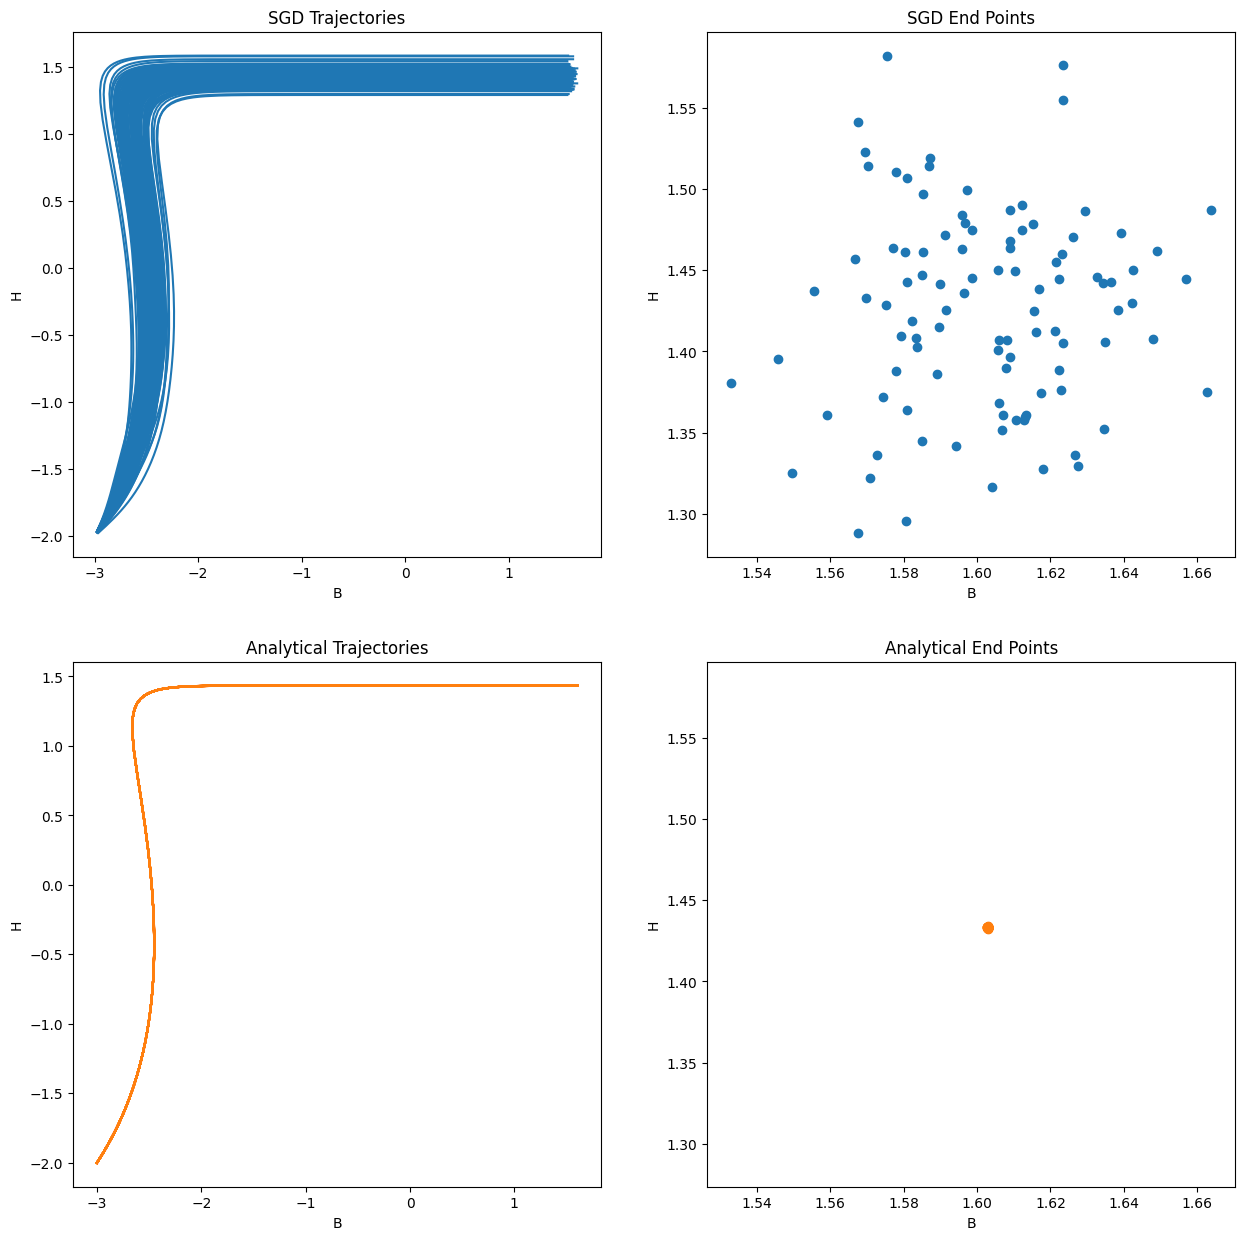

In [9]:
def case_a(n_runs):
  b_paths, h_paths = run_SGD_batch(case_a_jbh_config, case_a_sgd_config,
                                   n_runs=n_runs, plot_result=show_intermediate_steps)
  show_comparative(b_paths, h_paths,
                   thetas=load_analytical('content/Thetas_A.mat', 'Thetas_A'))
  savemat('content/case_a.mat', {'b_paths': b_paths, 'h_paths': h_paths})

case_a(100)

### Case B implementation

In [10]:
case_b_jbh_config = {
    "a": 1.21,
    "b": np.linspace(-2.0, 3.0, int(np.floor(5/0.2))),
    "c": 4.04,
    "g": 0.35,
    "h": np.linspace(-5.0, 1.0, int(np.floor(6/0.2))),
}
case_b_sgd_config = {
    "b_initial": -1,
    "h_initial": -4,
    "eps_b": 0.4,
    "eps_h": 0.4,
    "n_steps": 250
}

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


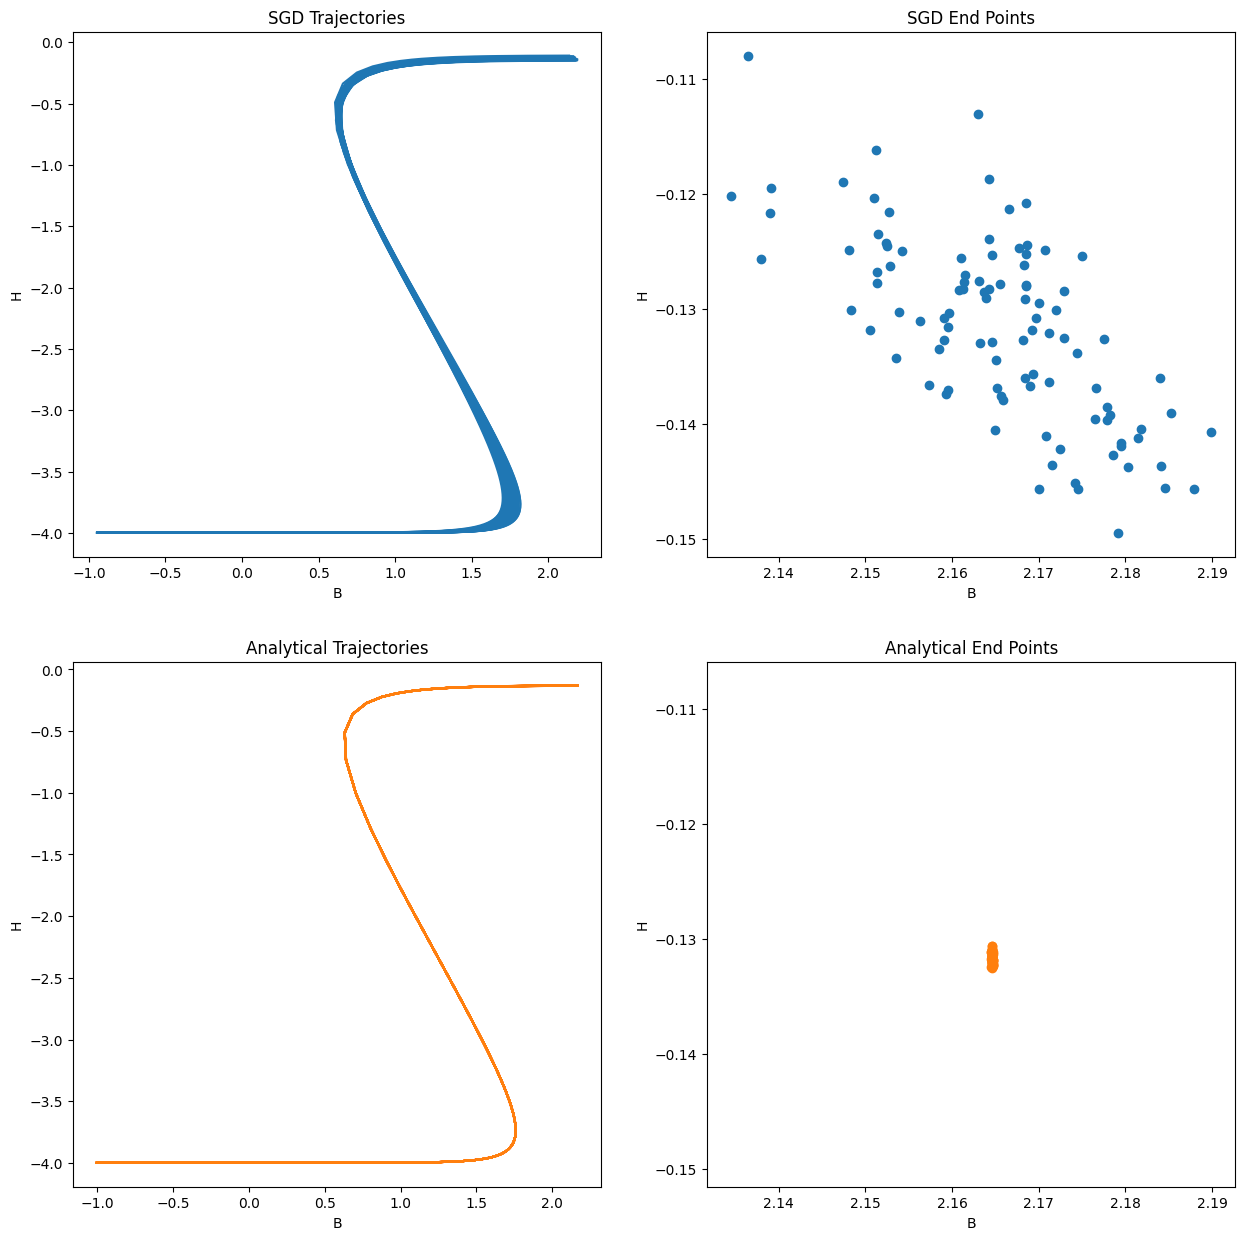

In [11]:
def case_b(n_runs):
  b_paths, h_paths = run_SGD_batch(case_b_jbh_config, case_b_sgd_config,
                                   n_runs=n_runs, plot_result=show_intermediate_steps)
  show_comparative(b_paths, h_paths,
                   thetas=load_analytical('content/Thetas_B.mat', 'Thetas_B'))
  savemat('content/case_b.mat', {'b_paths': b_paths, 'h_paths': h_paths})

case_b(100)